In [2]:
%pip install scikit-image cp-measure opencv-python imagecodecs -qU

Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the 'c:\Users\20212358\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [6]:
import cv2

shape before: (785, 785, 4)
shape after: (785, 785, 3)


c:\Users\20212358\AppData\Local\Programs\Python\Python310\lib\site-packages\cp_measure\core\measureobjectsizeshape.py:637: RuntimeWarning: divide by zero encountered in divide
  formfactor = 4.0 * numpy.pi * props["area"] / props["perimeter"] ** 2


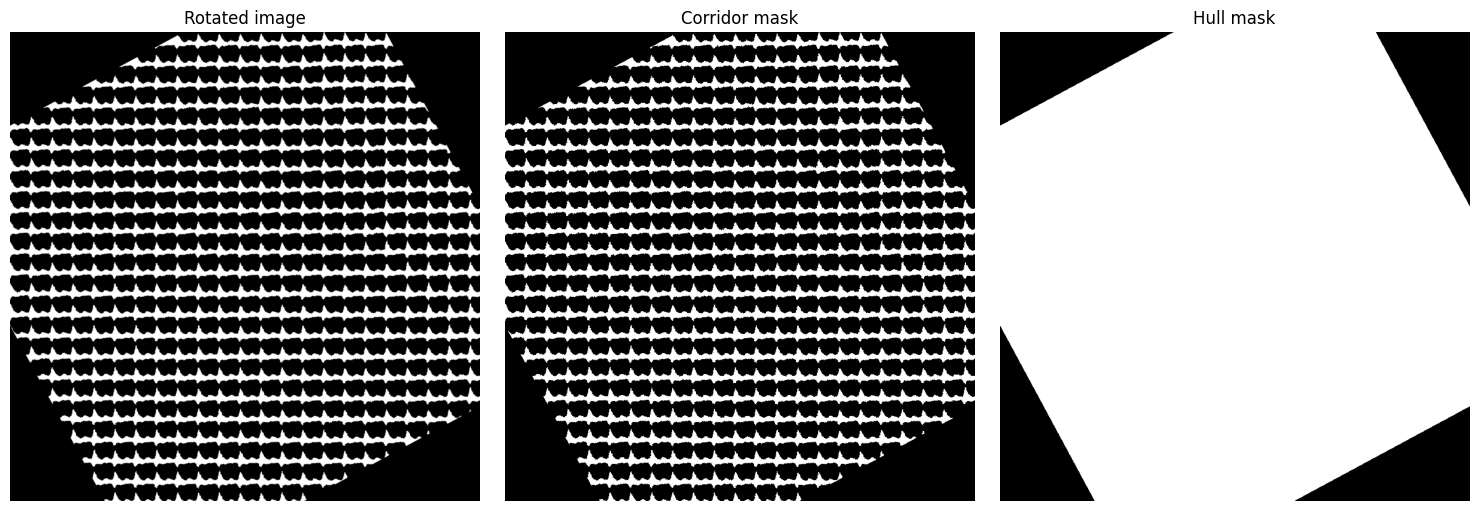

Detected rotation: 28.341 degrees
Detected 23 corridors.
Total matched windows: 609


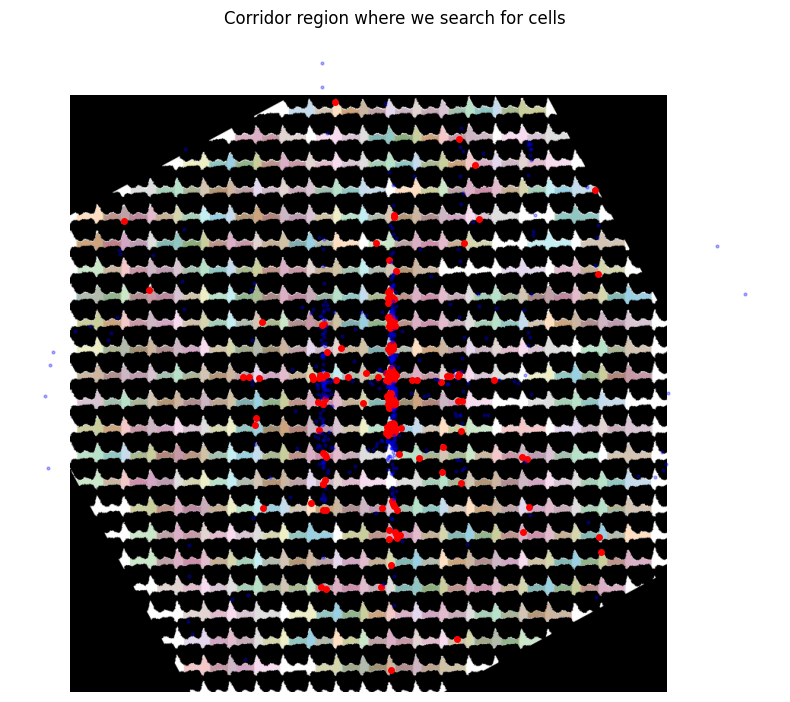

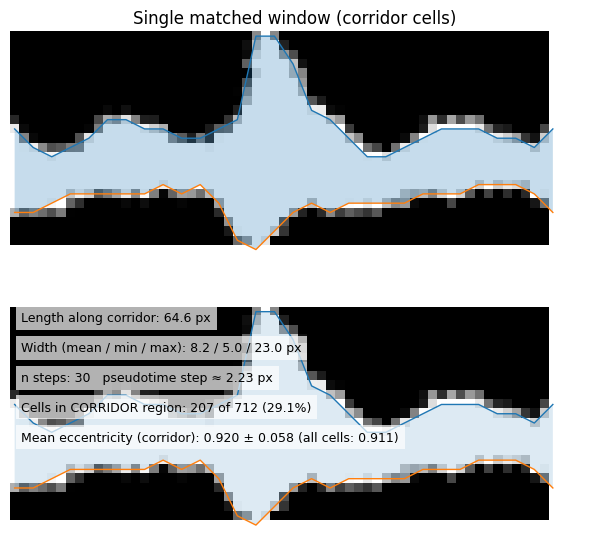

ValueError: too many values to unpack (expected 3)

In [2]:
from morphology_pipeline import pipeline
from tifffile import imread

background = r'C:\Users\20212358\OneDrive - TU Eindhoven\pseudotime_GitHUB\input images\FeatureIdx_1462.tif'
img = imread(background)
img = img[..., :3]
folder = r'C:\Users\20212358\Downloads\Nikita PhD BAZA\Chip_1462_1_real'
img = imread(background)
print("shape before:", img.shape)

# Если RGBA (4 канала) → отбрасываем альфу
if img.ndim == 3 and img.shape[-1] == 4:
    img = img[..., :3]     # оставляем только RGB

print("shape after:", img.shape)

SD, mask, selected_objs = pipeline.run_pipeline_and_save_csvs(
    img,
    None,
    None,
    folder
)



In [1]:
res = SD.dataframe.loc[mask]
res.info()


NameError: name 'SD' is not defined

c:\Users\20212358\AppData\Local\Programs\Python\Python310\lib\site-packages\cp_measure\core\measureobjectsizeshape.py:637: RuntimeWarning: divide by zero encountered in divide
  formfactor = 4.0 * numpy.pi * props["area"] / props["perimeter"] ** 2


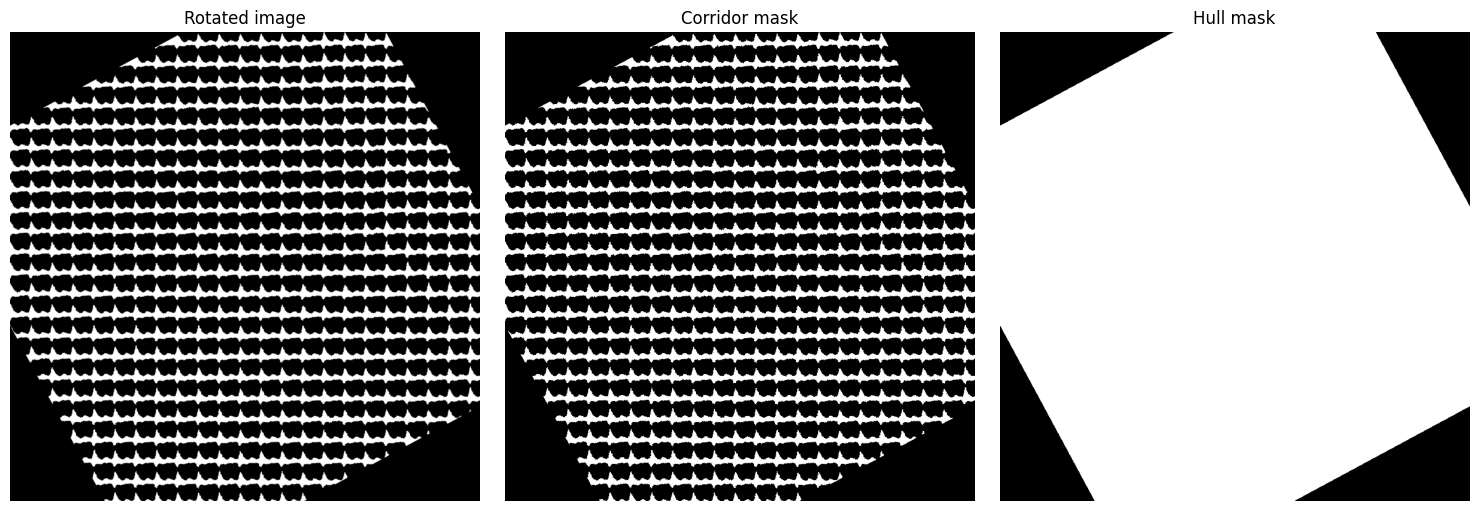

Detected rotation: 28.341 degrees
Detected 23 corridors.
Total matched windows: 609


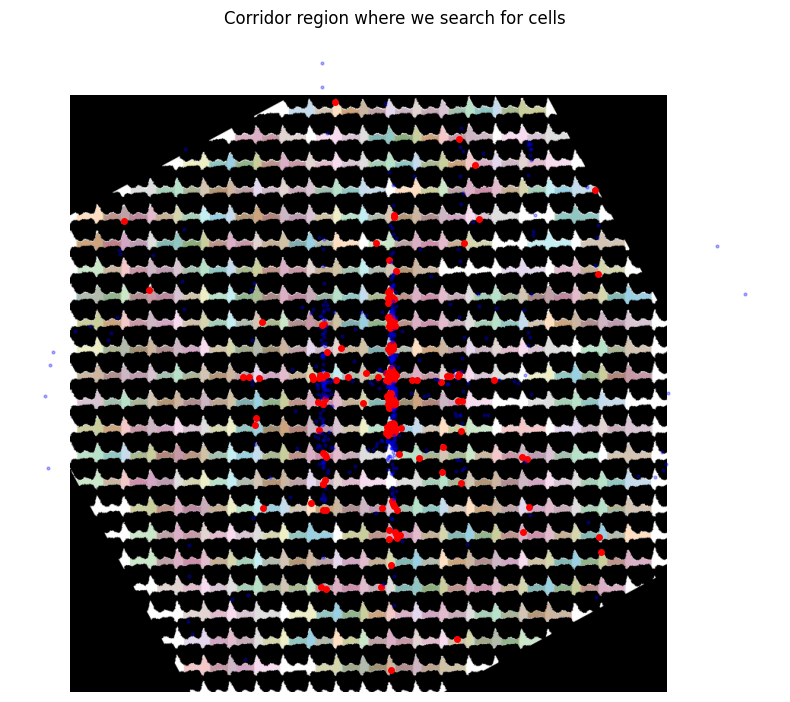

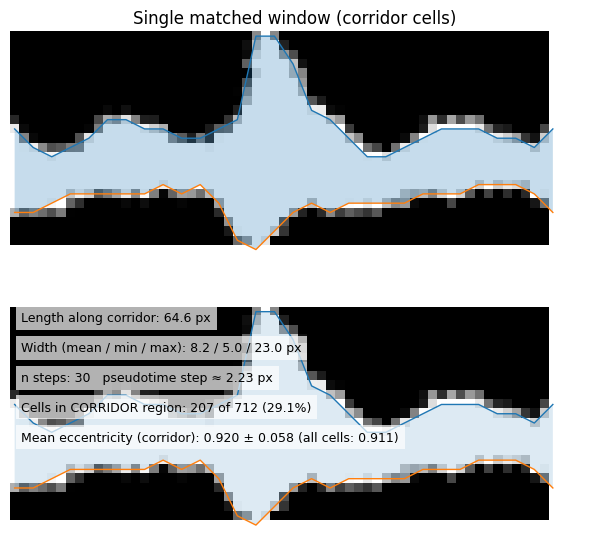

In [2]:
from morphology_pipeline import pipeline
import importlib
importlib.reload(pipeline)
from morphology_pipeline.pipeline import contains_point, eccentricity_profile_for_window
from tifffile import imread
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

background = r'C:\Users\20212358\OneDrive - TU Eindhoven\pseudotime_GitHUB\input images\FeatureIdx_1462.tif'
folder = r'C:\Users\20212358\Downloads\Nikita PhD BAZA\Chip_1462_1_real'

from morphology_pipeline import pipeline
import importlib
import matplotlib.pyplot as plt

importlib.reload(pipeline)

from tifffile import imread



img = imread(background)
if img.ndim == 3 and img.shape[-1] == 4:
    img = img[..., :3]

SD, mask, selected_objs, window_infos, centers_rot_map = pipeline.run_pipeline_and_save_csvs(
    img,
    None,
    None,
    folder,
)


In [4]:
import numpy as np
from morphology_pipeline.pipeline import contains_point  # from your file

def length_along_window(xs, yt, yb):
    """Polyline length along midline of a single window."""
    xs = np.asarray(xs, float)
    yt = np.asarray(yt, float)
    yb = np.asarray(yb, float)
    y_mid = 0.5 * (yt + yb)
    dx = np.diff(xs)
    dy = np.diff(y_mid)
    seg_lengths = np.sqrt(dx**2 + dy**2)
    return float(seg_lengths.sum())

def global_s_for_corridor(window_infos, centers_rot_map, SD, mask,
                          shift_x=0.0, shift_y=0.0):
    """
    Map each corridor cell to a global pseudotime s_global along the
    whole corridor by stacking windows one after another.

    Returns
    -------
    cells : list of dict
        Each dict has keys:
        - 's_global': position along corridor
        - 'ecc': eccentricity value
    total_len : float
        Total corridor length in pixels.
    """
    # precompute per-window length and running offsets
    Ls = []
    for win, xs, yt, yb in window_infos:
        Ls.append(length_along_window(xs, yt, yb))
    Ls = np.asarray(Ls, float)
    offsets = np.concatenate(([0.0], np.cumsum(Ls[:-1])))  # same length as window_infos
    total_len = float(offsets[-1] + Ls[-1])

    # eccentricity as scalar
    ecc_raw = SD.dataframe["eccentricity"]

    def _as_float(x):
        arr = np.asarray(x)
        if arr.size == 0:
            return np.nan
        return float(arr.ravel()[0])

    ecc_all = ecc_raw.apply(_as_float)

    cells = []
    corridor_idx = np.where(mask)[0]

    for idx in corridor_idx:
        obj_id = SD.dataframe.index[idx]
        if obj_id not in centers_rot_map:
            continue

        cxr, cyr = centers_rot_map[obj_id]
        cx_loc = cxr - shift_x
        cy_loc = cyr - shift_y

        # try all windows, find the first that contains the cell
        for j, (win, xs, yt, yb) in enumerate(window_infos):
            xs = np.asarray(xs, float)
            yt = np.asarray(yt, float)
            yb = np.asarray(yb, float)

            if not contains_point(cx_loc, cy_loc, xs, yt, yb):
                continue

            # build local s for this window
            y_mid = 0.5 * (yt + yb)
            dx = np.diff(xs)
            dy = np.diff(y_mid)
            seg_lengths = np.sqrt(dx**2 + dy**2)
            s_local = np.concatenate(([0.0], np.cumsum(seg_lengths)))

            # interpolate local s for this cell
            i = np.searchsorted(xs, cx_loc)
            i = int(np.clip(i, 1, len(xs) - 1))
            x0, x1 = xs[i-1], xs[i]
            t = (cx_loc - x0) / (x1 - x0) if x1 != x0 else 0.0
            s_cell_local = s_local[i-1] + t * (s_local[i] - s_local[i-1])

            # global s = offset of this window + local s
            s_global = offsets[j] + s_cell_local

            ecc_val = ecc_all.iloc[idx]
            if not np.isnan(ecc_val):
                cells.append({"s_global": float(s_global),
                              "ecc": float(ecc_val)})
            break  # stop after first containing window

    return cells, total_len


min s_global: 94.9324747842351
max s_global: 38550.34976700617
first 20 s_global sorted: [   94.93247478  1532.89679209  2786.94367028  4533.88011347
  4636.85131176  5802.06760099  5802.1318737   6190.11785998
  7819.79179486  8063.98970473  9625.01151684  9635.80474762
 10040.85980949 10456.08007054 11603.16453465 11603.998021
 11604.01877355 11605.18774156 11606.10569653 11606.40201379]


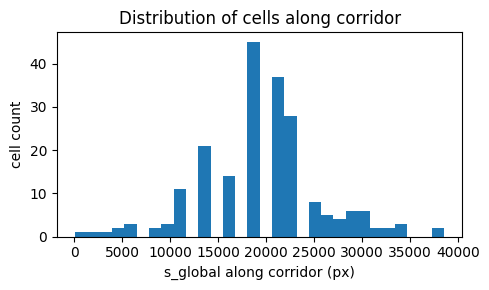

In [9]:
import numpy as np
import matplotlib.pyplot as plt

s_vals = np.array([c["s_global"] for c in cells_corridor])

print("min s_global:", s_vals.min())
print("max s_global:", s_vals.max())
print("first 20 s_global sorted:", np.sort(s_vals)[:20])

plt.figure(figsize=(5,3))
plt.hist(s_vals, bins=30)
plt.xlabel("s_global along corridor (px)")
plt.ylabel("cell count")
plt.title("Distribution of cells along corridor")
plt.tight_layout()
plt.show()


In [10]:
def corridor_ecc_profile_sliding(cells, total_len,
                                 window_width_px=500.0,
                                 step_px=250.0):
    """
    Sliding-window profile of mean eccentricity along the corridor.

    Parameters
    ----------
    cells : list of dict
        Output from global_s_for_corridor:
        each dict has 's_global' and 'ecc'.
    total_len : float
        Total corridor length (px).
    window_width_px : float
        Width of the sliding window in px.
    step_px : float
        Step between window centers in px.

    Returns
    -------
    df : pandas.DataFrame
        Columns:
        - center_s : window center position
        - s_min, s_max : window bounds
        - mean_ecc, std_ecc
        - n_cells
    """
    s_vals = np.array([c["s_global"] for c in cells], dtype=float)
    ecc_vals_all = np.array([c["ecc"] for c in cells], dtype=float)

    centers = np.arange(window_width_px/2, total_len - window_width_px/2 + 1,
                        step_px)

    rows = []
    for c_s in centers:
        s_min = c_s - window_width_px / 2
        s_max = c_s + window_width_px / 2

        mask_win = (s_vals >= s_min) & (s_vals <= s_max)
        ecc_win = ecc_vals_all[mask_win]

        if ecc_win.size > 0:
            mean_ecc = float(ecc_win.mean())
            std_ecc = float(ecc_win.std())
            n_cells = int(ecc_win.size)
        else:
            mean_ecc = np.nan
            std_ecc = np.nan
            n_cells = 0

        rows.append(dict(
            center_s=c_s,
            s_min=s_min,
            s_max=s_max,
            mean_ecc=mean_ecc,
            std_ecc=std_ecc,
            n_cells=n_cells,
        ))

    return pd.DataFrame(rows)


   center_s   s_min   s_max  mean_ecc  std_ecc  n_cells
0     500.0     0.0  1000.0  0.928845      0.0        1
1    1000.0   500.0  1500.0       NaN      NaN        0
2    1500.0  1000.0  2000.0  0.957214      0.0        1
3    2000.0  1500.0  2500.0  0.957214      0.0        1
4    2500.0  2000.0  3000.0  0.919174      0.0        1


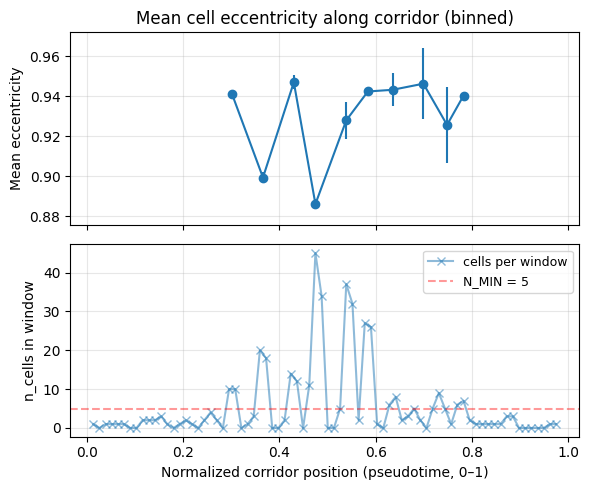

     pseudo01  mean_ecc   std_ecc  n_cells  n_windows
bin                                                  
5    0.301512  0.941005  0.000000       20          2
6    0.365663  0.899457  0.002803       38          2
7    0.429814  0.947007  0.003479       26          2
8    0.474720  0.886211  0.002273       90          3
9    0.538872  0.928016  0.009181       74          3
10   0.583778  0.942416  0.001809       53          2
11   0.635099  0.943249  0.008255       14          2
12   0.699250  0.946305  0.017646       10          2
13   0.748433  0.925717  0.018831       20          3
14   0.782647  0.940331  0.000000        7          1


In [16]:
# --- compute sliding-window profile ---
df_slide = corridor_ecc_profile_sliding(
    cells_corridor,
    total_len,
    window_width_px=1000.0,   # 1000 px chunks
    step_px=500.0,            # 50% overlap
)

print(df_slide.head())

# --- starting point: df_slide from corridor_ecc_profile_sliding ---
# df_slide has columns: center_s, s_min, s_max, mean_ecc, std_ecc, n_cells
# total_len is the stacked corridor length

N_MIN = 5          # minimum cells per window
N_BINS = 18        # how many pseudotime bins

df = df_slide.copy()
df["pseudo01"] = df["center_s"] / total_len
df = df.sort_values("pseudo01")

# keep only well-sampled windows
df_good = df[df["n_cells"] >= N_MIN].copy()

# bin pseudotime into N_BINS groups in [0, 1]
bins = np.linspace(0.0, 1.0, N_BINS + 1)
df_good["bin"] = pd.cut(
    df_good["pseudo01"],
    bins=bins,
    labels=False,
    include_lowest=True,
)

# aggregate inside each bin
prof = (
    df_good
    .groupby("bin")
    .agg(
        pseudo01=("pseudo01", "mean"),     # bin center
        mean_ecc=("mean_ecc", "mean"),
        std_ecc=("mean_ecc", "std"),
        n_cells=("n_cells", "sum"),        # total cells contributing
        n_windows=("mean_ecc", "size"),    # how many windows in this bin
    )
    .dropna(subset=["pseudo01"])
)

# replace NaN std (single window) with 0 for plotting
prof["std_ecc"] = prof["std_ecc"].fillna(0.0)

# ------------------------------------------------------------------
# PLOTTING: 2 stacked panels (binned ecc + raw n_cells per window)
# ------------------------------------------------------------------
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 5), sharex=True)

# TOP: binned mean eccentricity
ax1.errorbar(
    prof["pseudo01"],
    prof["mean_ecc"],
    yerr=prof["std_ecc"],
    marker="o",
    linestyle="-",
    linewidth=1.5,
)

ax1.set_ylabel("Mean eccentricity")
ax1.set_title("Mean cell eccentricity along corridor (binned)")
ax1.grid(True, alpha=0.3)

# ensure full visibility of error bars: use mean ± std
y_min = (prof["mean_ecc"] - prof["std_ecc"]).min()
y_max = (prof["mean_ecc"] + prof["std_ecc"]).max()

# add a bit of padding
if np.isfinite(y_min) and np.isfinite(y_max):
    span = y_max - y_min
    if span == 0:
        span = 0.01  # fallback to something small
    margin = 0.1 * span   # 10% padding
    ax1.set_ylim(y_min - margin, y_max + margin)


# BOTTOM: number of cells in each sliding window (raw)
ax2.plot(
    df["pseudo01"],
    df["n_cells"],
    marker="x",
    linestyle="-",
    alpha=0.5,
    label="cells per window",
)
ax2.axhline(
    N_MIN,
    color="red",
    linestyle="--",
    alpha=0.4,
    label=f"N_MIN = {N_MIN}",
)

ax2.set_xlabel("Normalized corridor position (pseudotime, 0–1)")
ax2.set_ylabel("n_cells in window")
ax2.grid(True, alpha=0.3)
ax2.legend(loc="upper right", fontsize=9)

plt.tight_layout()
plt.show()

print(prof)




   center_s   s_min   s_max  mean_ecc  std_ecc  n_cells
0     500.0     0.0  1000.0  0.928845      0.0        1
1    1000.0   500.0  1500.0       NaN      NaN        0
2    1500.0  1000.0  2000.0  0.957214      0.0        3
3    2000.0  1500.0  2500.0  0.957214      0.0        3
4    2500.0  2000.0  3000.0  0.919174      0.0        2
Selected window index 330 with 30 cells
Cells in selected window: 30


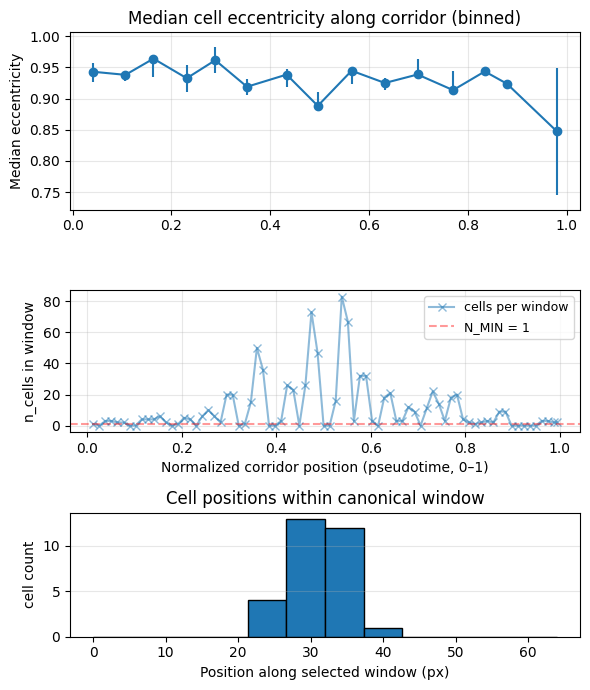

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# 1) Sliding-window profile along the *global* corridor
# ============================================================

def corridor_ecc_profile_sliding(cells_corridor,
                                 total_len,
                                 window_width_px=1000.0,
                                 step_px=500.0):
    """
    cells_corridor : list of dicts with at least
        - 's_global'  (arc length in px along full corridor)
        - 'eccentricity'
    total_len : float
        Total corridor length (px).
    """
    s_arr = np.array([c["s_global"] for c in cells_corridor], dtype=float)
    ecc_arr = np.array([c["eccentricity"] for c in cells_corridor], dtype=float)

    rows = []
    w = float(window_width_px)
    step = float(step_px)

    s_start = 0.0
    while s_start < total_len:
        s_end = min(total_len, s_start + w)
        center_s = 0.5 * (s_start + s_end)

        in_win = (s_arr >= s_start) & (s_arr < s_end)
        ecc_vals = ecc_arr[in_win]

        if ecc_vals.size > 0:
            mean_ecc = float(ecc_vals.mean())
            std_ecc = float(ecc_vals.std())
            n_cells = int(ecc_vals.size)
        else:
            mean_ecc = np.nan
            std_ecc = np.nan
            n_cells = 0

        rows.append(
            dict(
                center_s=center_s,
                s_min=s_start,
                s_max=s_end,
                mean_ecc=mean_ecc,
                std_ecc=std_ecc,
                n_cells=n_cells,
            )
        )

        s_start += step

    return pd.DataFrame(rows)


# --- compute sliding-window profile ---
df_slide = corridor_ecc_profile_sliding(
    cells_corridor,
    total_len,
    window_width_px=1000.0,   # 1000 px chunks
    step_px=500.0,            # 50% overlap
)

print(df_slide.head())

# --- starting point: df_slide from corridor_ecc_profile_sliding ---
# df_slide has columns: center_s, s_min, s_max, mean_ecc, std_ecc, n_cells

N_MIN = 1          # minimum cells per window (you used 1 in the screenshot)
N_BINS = 15        # how many pseudotime bins

df = df_slide.copy()
df["pseudo01"] = df["center_s"] / total_len
df = df.sort_values("pseudo01")

# keep only well-sampled windows
df_good = df[df["n_cells"] >= N_MIN].copy()

# bin pseudotime into N_BINS groups in [0, 1]
bins = np.linspace(0.0, 1.0, N_BINS + 1)
df_good["bin"] = pd.cut(
    df_good["pseudo01"],
    bins=bins,
    labels=False,
    include_lowest=True,
)

# --- aggregate inside each bin: MEDIAN + IQR -----------------------
prof = (
    df_good
    .groupby("bin")
    .agg(
        pseudo01=("pseudo01", "mean"),              # bin center on x-axis
        median_ecc=("mean_ecc", "median"),          # median of window means
        q25=("mean_ecc", lambda x: x.quantile(0.25)),
        q75=("mean_ecc", lambda x: x.quantile(0.75)),
        n_cells=("n_cells", "sum"),                 # total cells contributing
        n_windows=("mean_ecc", "size"),             # number of windows in bin
    )
    .dropna(subset=["pseudo01"])
)

# error bars: from median to 25th / 75th percentile (asymmetric)
err_low  = prof["median_ecc"] - prof["q25"]
err_high = prof["q75"]        - prof["median_ecc"]
yerr = np.vstack([err_low.values, err_high.values])


# ============================================================
# 2) Distribution of cells along a *single matched window*
# ============================================================

# helper: how many corridor cells fall into this particular window
def count_cells_in_window(xs, yt, yb, centers_rot_map, SD, mask):
    cnt = 0
    for obj_id, (cx, cy) in centers_rot_map.items():
        idx = SD.dataframe.index.get_loc(obj_id)
        if not mask[idx]:
            continue
        if contains_point(cx, cy, xs, yt, yb):
            cnt += 1
    return cnt

# choose the window with the largest number of corridor cells
win_counts = []
for win, xs_w, yt_w, yb_w in window_infos:
    win_counts.append(count_cells_in_window(xs_w, yt_w, yb_w,
                                            centers_rot_map, SD, mask))

best_idx = int(np.argmax(win_counts))
win_sel, xs_sel, yt_sel, yb_sel = window_infos[best_idx]
print(f"Selected window index {best_idx} with {win_counts[best_idx]} cells")

xs_sel = np.asarray(xs_sel, dtype=float)
yt_sel = np.asarray(yt_sel, dtype=float)
yb_sel = np.asarray(yb_sel, dtype=float)

# geometry of this window: arc-length coordinate along midline
y_mid_sel = 0.5 * (yt_sel + yb_sel)
dx_sel = np.diff(xs_sel)
dy_sel = np.diff(y_mid_sel)
seg_len_sel = np.sqrt(dx_sel**2 + dy_sel**2)
s_sel = np.concatenate(([0.0], np.cumsum(seg_len_sel)))
L_win = float(s_sel[-1])   # length of canonical window in pixels (≈ 64.6 px)

# compute local arc-length for each corridor cell that lies in this window
local_s = []
for obj_id, (cx, cy) in centers_rot_map.items():
    idx = SD.dataframe.index.get_loc(obj_id)
    if not mask[idx]:
        continue
    if not contains_point(cx, cy, xs_sel, yt_sel, yb_sel):
        continue

    i = np.searchsorted(xs_sel, cx)
    i = int(np.clip(i, 1, len(xs_sel) - 1))
    x0 = xs_sel[i - 1]
    x1 = xs_sel[i]
    if x1 != x0:
        t = (cx - x0) / (x1 - x0)
    else:
        t = 0.0

    s_cell = s_sel[i - 1] + t * (s_sel[i] - s_sel[i - 1])
    local_s.append(s_cell)

local_s = np.asarray(local_s, dtype=float)
print(f"Cells in selected window: {local_s.size}")

# 1D histogram of positions along the window
N_BINS_WIN = 12
bins_win = np.linspace(0.0, L_win, N_BINS_WIN + 1)
hist, edges = np.histogram(local_s, bins=bins_win)
bin_centers = 0.5 * (edges[:-1] + edges[1:])


# ============================================================
# 3) PLOTTING: 3 stacked panels
# ============================================================

fig, (ax1, ax2, ax3) = plt.subplots(
    3, 1,
    figsize=(6, 7),
    gridspec_kw={"height_ratios": [2.0, 1.6, 1.4]},
    sharex=False
)

# --- TOP: binned MEDIAN ecc vs global pseudotime ------------------
ax1.errorbar(
    prof["pseudo01"],
    prof["median_ecc"],
    yerr=yerr,
    marker="o",
    linestyle="-",
    linewidth=1.5,
)
ax1.set_ylabel("Median eccentricity")
ax1.set_title("Median cell eccentricity along corridor (binned)")
ax1.grid(True, alpha=0.3)

y_min = prof["q25"].min()
y_max = prof["q75"].max()
if np.isfinite(y_min) and np.isfinite(y_max):
    span = y_max - y_min
    if span == 0:
        span = 0.01
    margin = 0.1 * span
    ax1.set_ylim(y_min - margin, y_max + margin)

# --- MIDDLE: cells per sliding window vs global pseudotime --------
ax2.plot(
    df["pseudo01"],
    df["n_cells"],
    marker="x",
    linestyle="-",
    alpha=0.5,
    label="cells per window",
)
ax2.axhline(
    N_MIN,
    color="red",
    linestyle="--",
    alpha=0.4,
    label=f"N_MIN = {N_MIN}",
)
ax2.set_ylabel("n_cells in window")
ax2.grid(True, alpha=0.3)
ax2.legend(loc="upper right", fontsize=9)
ax2.set_xlabel("Normalized corridor position (pseudotime, 0–1)")

# --- BOTTOM: where inside the selected 64.6-px window cells sit ---
ax3.bar(bin_centers, hist, width=np.diff(edges), align="center", edgecolor="k")
ax3.set_xlabel("Position along selected window (px)")
ax3.set_ylabel("cell count")
ax3.set_title("Cell positions within canonical window")
ax3.grid(True, axis="y", alpha=0.3)

plt.tight_layout()
plt.show()


In [40]:
def collect_cells_window_positions_with_ecc(window_infos,
                                            centers_rot_map,
                                            SD,
                                            mask,
                                            ecc_col: str = "eccentricity"):
    """
    Для всех клеток в коридоре (mask == True) находим их положение вдоль
    того окна, в которое центр попадает, и вытаскиваем эксцентриситет.

    Возвращает:
        df_cells : DataFrame с колонками
            - obj_id : индекс клетки в SD.dataframe
            - s_px   : позиция вдоль локального окна (в пикселях, 0..L_win)
            - s_norm : нормированная позиция вдоль окна (0..1)
            - ecc    : эксцентриситет (float)
        L_ref : float
            Средняя длина окна (в пикселях) по всем использованным окнам.
    """
    df = SD.dataframe

    if ecc_col not in df.columns:
        raise KeyError(f"Column '{ecc_col}' not found in SD.dataframe")

    # конвертация значения эксцентриситета к float (если там массивы)
    def _as_float(x):
        arr = np.asarray(x)
        if arr.size == 0:
            return np.nan
        return float(arr.ravel()[0])

    ecc_all = df[ecc_col].apply(_as_float)

    records = []
    L_list = []

    # идём по всем клеткам, которые лежат в коридоре
    for obj_id, (cx, cy) in centers_rot_map.items():
        row_idx = df.index.get_loc(obj_id)
        if not mask[row_idx]:
            continue  # вне коридора

        ecc_val = ecc_all.iloc[row_idx]
        if np.isnan(ecc_val):
            continue

        # ищем окно, в которое попадает эта клетка
        for (win, xs, yt, yb) in window_infos:
            xs = np.asarray(xs, dtype=float)
            yt = np.asarray(yt, dtype=float)
            yb = np.asarray(yb, dtype=float)

            if not contains_point(cx, cy, xs, yt, yb):
                continue

            # считаем геометрию окна: длина вдоль середины
            y_mid = 0.5 * (yt + yb)
            dx = np.diff(xs)
            dy = np.diff(y_mid)
            seg_len = np.sqrt(dx**2 + dy**2)
            s = np.concatenate(([0.0], np.cumsum(seg_len)))
            L_win = float(s[-1])
            if L_win <= 0:
                break

            # локальная координата s_cell
            i = np.searchsorted(xs, cx)
            i = int(np.clip(i, 1, len(xs) - 1))
            x0, x1 = xs[i - 1], xs[i]
            if x1 != x0:
                t = (cx - x0) / (x1 - x0)
            else:
                t = 0.0

            s_cell = s[i - 1] + t * (s[i] - s[i - 1])  # в пикселях вдоль окна
            s_norm = s_cell / L_win                     # 0..1 вдоль окна

            records.append(
                dict(
                    obj_id=obj_id,
                    s_px=float(s_cell),
                    s_norm=float(s_norm),
                    ecc=float(ecc_val),
                )
            )
            L_list.append(L_win)
            break  # выходим после первого подходящего окна

    if not records:
        df_cells = pd.DataFrame(columns=["obj_id", "s_px", "s_norm", "ecc"])
        return df_cells, np.nan

    df_cells = pd.DataFrame.from_records(records)
    L_ref = float(np.mean(L_list))
    return df_cells, L_ref


In [41]:
df_cells_win, L_ref = collect_cells_window_positions_with_ecc(
    window_infos,
    centers_rot_map,
    SD,
    mask,
    ecc_col="eccentricity",
)

print(df_cells_win.head())
print("n cells in df_cells_win:", len(df_cells_win))
print("Mean window length L_ref ≈", L_ref)


   obj_id       s_px    s_norm       ecc
0       9  44.593191  0.697444  0.987409
1      10  28.727654  0.460087  0.928670
2      11  35.580377  0.557467  0.866207
3      12  47.567682  0.749985  0.959000
4      14  63.104175  0.990182  0.985514
n cells in df_cells_win: 207
Mean window length L_ref ≈ 64.1491158987649


In [42]:
# бин по целым пикселям вдоль окна
df_cells_win["x_px_round"] = df_cells_win["s_px"].round().astype(int)

# группируем по пикселю
grouped = (
    df_cells_win
    .groupby("x_px_round")
    .agg(
        mean_ecc=("ecc", "mean"),
        median_ecc=("ecc", "median"),
        std_ecc=("ecc", "std"),
        n_cells=("ecc", "size"),
    )
    .sort_index()
)

print(grouped.head())
print("shape:", grouped.shape)


            mean_ecc  median_ecc   std_ecc  n_cells
x_px_round                                         
5           0.966682    0.966682       NaN        1
11          0.845357    0.845357       NaN        1
25          0.910094    0.910094       NaN        1
26          0.932328    0.932328       NaN        1
27          0.932184    0.925354  0.026998        3
shape: (40, 4)


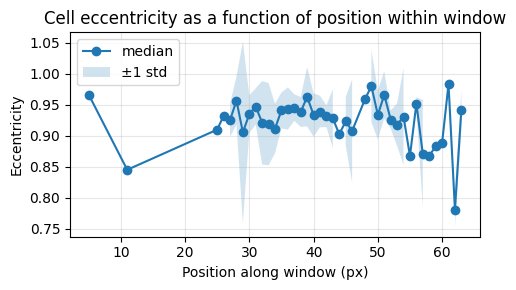

: 

In [ ]:
fig, ax = plt.subplots(figsize=(5, 3))

ax.plot(grouped.index, grouped["median_ecc"], marker="o", linestyle="-", label="median")
ax.fill_between(
    grouped.index,
    grouped["median_ecc"] - grouped["std_ecc"],
    grouped["median_ecc"] + grouped["std_ecc"],
    alpha=0.2,
    label="±1 std",
)

ax.set_xlabel("Position along window (px)")
ax.set_ylabel("Eccentricity")
ax.set_title("Cell eccentricity as a function of position within window")
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()
